*Load packages and data:*

In [1]:
%run stdPackages.ipynb
read = {'variables': ['Fundamentals', 'Load', 'Generators_Other'], 
        'variable2D': ['Generators_FuelMix','HourlyVariation'],
        'scalars': ['MWP'],
        'maps': ['Generators_Categories']}
db = dbFromWB(os.path.join(d['data'],'E2.xlsx'), read)
readSets(db)

# Exercise 2: Capacity factors

### Problem 1: Utilization of generation capacities

First, we set up and solve the model using the 'usual' syntax:

In [2]:
m = mBasicInt.mBasicInt(db) # initialize using the database 'db' from above.
m.solve() # solve model

Solution status 0: Optimization terminated successfully.


Next, compute the theoretical and practical generating capacity:

In [3]:
qDay_T = m.db['GeneratingCapacity'] * len(m.db['h']) # daily, theoretical capacity
qDay_P = m.hourlyGeneratingCapacity.groupby('id').sum() # daily, practical capacity

Define the daily generation by summing over $h$ (or ```groupby``` ```id``` in pandas):

In [4]:
dailyGeneration = m.db['Generation'].groupby('id').sum()

Now, we can compute capacity factors:

In [5]:
TCF = dailyGeneration/qDay_T
PCF = dailyGeneration/qDay_P

In [6]:
df = pd.DataFrame({'TCF': TCF, 'PCF': PCF, 'MC': m.db['mc']}).sort_values(by='MC')
df

,TCF,PCF,MC
id,,,
id4,0.6375,1.0,3.0
id1,0.585,0.585,6.189324
id2,0.5,0.5,9.560114
id3,0.34375,0.34375,15.402685


Inspecting the two, we see that for *dispatchable plants* (id1-id3), the TCF is equal the PCF per construction. For the wind turbine, however, we have that $PCF\geq TCF$ by construction. More specifically, we note the following:
* *All three dispatchable plants have a TCF<1*: As we can see from inspecting the merit order curves below, the three dispathable plants are all active in hours $2, 3$, but only the coal plant (id1) is active in hours $1, 4$.
* *Wind turbine PCF and TCF*: The TCF is $0.6375$ for the wind turbine. Note, however, that this is only due to variation in natural conditions: The wind turbine produces at much as it can for each hour (see the merit order curves). This is confirmed by the PCF that is exactly $1$.

*EXTRA: This plots the relation between the three variables with marginal costs plotted against a second y-axis:*

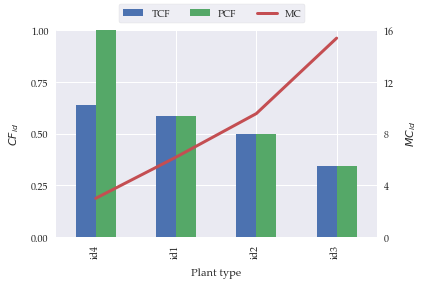

In [7]:
fig, ax1 = plt.subplots(1,1,figsize = (6,4)) # create plot, specify number of subplots and size 
ax2 = ax1.twinx() # create a second y-axis
df[['TCF','PCF']].plot.bar(ax=ax1, legend=False, linewidth=0) # plot the TCF and PCF in as bars on the first axis. Remove lines and legends.
ax1.set_yticks(np.linspace(0, 1, 5)) # Set ticks in specific places.
ax1.set_ylim([0, 1]); # specify scale on y-axis.
ax1.set_ylabel('$CF_{id}$', labelpad=10); 
ax1.set_xlabel('Plant type', labelpad=10);

df['MC'].plot(ax=ax2, legend=False, linewidth=3, color = colors[2]); # plot the MC on the second axis. Remove legend and set color.
ax2.set_yticks(np.linspace(0, 16, 5)) # Set ticks in specific places.
ax2.set_ylim([0, 16]); # Set limit to y axis
ax2.set_ylabel('$MC_{id}$', labelpad=10); 
ax2.grid(None); # remove grid-lines; we have made sure that gridlines coincide with the grid from ax1.

fig.legend(['TCF', 'PCF', 'MC'],loc=9,ncol=3,frameon=True) # create legend and place outside the box.
fig.tight_layout();
fig.subplots_adjust(top=0.9); # adjust the plot downwards to allow for room for the legend to be plotted outside the figure

### Problem 2: Average costs of capacity and average costs of energy

Let's start by setting up the total costs (TC) of a plant. These are given by:
$$\begin{align}
    TC_{id} = \text{FOM}_{id}\cdot \text{GeneratingCapacity}_{id}\cdot \dfrac{4}{8760} + \text{mc}_{id}\cdot \sum_h E_{i,h} / 1000.
\end{align}$$
* We adjust the fixed costs by $4/8760$ as the current model only uses 4 hours and $FOM$ is a measure of costs for 8760 hours (a year). 
* We divide the generating costs (second term) by 1000 to take into account that fixed costs are naturally measured in "1000€" whereas variable, generation costs are measured in "€".

$TC_{id}$ is thus the plants total costs measured in 1000€.

In [8]:
TC = m.db['FOM'] * m.db['GeneratingCapacity'] * len(m.db['h'])/8760 + m.db['mc'] * pdSum(m.db['Generation'], 'h') / 1000 
TC

id
id1    0.920752
id2    0.685098
id3      1.4899
id4    0.489719
dtype: object

With this in mind, we define the average capacity costs and average energy costs by dividing by the appropriate variables (here we multiply by 1000 again to measure it in € instead):

In [9]:
DF = pd.DataFrame(dict(ACC = 1000 * TC / m.db['GeneratingCapacity'], 
                       AEC = 1000 * TC / pdSum(m.db['Generation'], 'h'),
                       MC  = m.db['mc']
                      )).sort_values(by='MC')
DF

,ACC,AEC,MC
id,,,
id4,13.991958,5.487043,3.0
id1,18.415032,7.869672,6.189324
id2,22.836616,11.418308,9.560114
id3,24.831659,18.059389,15.402685


We can also plot it directly using pandas feature:

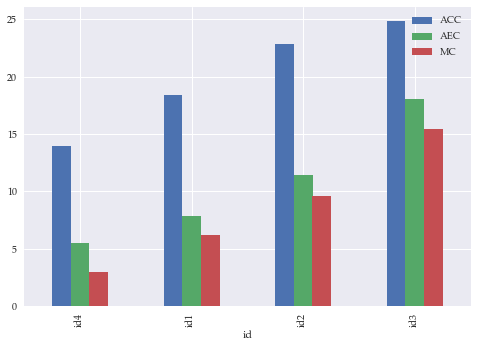

In [10]:
DF.plot.bar();

Comments on the solution:
* The three variables follows the same ordering: wind (id4), coal (id1), gas (id2), bio (id3). This suggests that wind is generally the most cost-effective technology available.
* The fixed costs are very similar for id2-id4 and somewhat higher for the wind plant (id4).
* Recall that we have not yet included investment costs in this comparison.

### Problem 3: Economic value of capacity

#### 3.1. *Compute the weighted average marginal system costs across the $h$ hours (use 'HourlyDemand' as weights)*


Get marginal system costs $(\lambda)$ and hourly consumption levels $(d)$:

In [11]:
λ = mBasicInt.marginalSystemCosts(m.db)
d = m.db['HourlyDemand']

The weighted average is defined as *(the function ```pdSum(x,i)``` sums the variable ```x``` over the index ```i``` when $x$ is a ```pd.Series``` or ```pd.DataFrame```)*:

In [12]:
λ_average = pdSum( d * λ / pdSum(d, 'h'), 'h')
λ_average

17.382704133107744

#### 3.2. *Define and compute the weighted average marginal system costs for all ids*

The weighted average marginal system costs for ids is defined as above, but using ```Generation``` as weights:

In [13]:
w = m.db['Generation']
λ_ids = pdSum( w * λ / pdSum(w, 'h'), 'h')
λ_ids

id
id1    18.165408
id2    20.201342
id3    22.382550
id4     9.840049
dtype: float64

#### 3.3. *Compute the marginal economic value of generating capacity for all plants.*

From the note "*Models for Energy Economics*" we know that the marginal economic value of generating capacity can be defined as:
$$\begin{align}
    \dfrac{\partial \mathcal{L}}{\partial q_i} = \sum_h \overline{\vartheta}_{i,h} \gamma_{i,h},
\end{align}$$
where $\mathcal{L}$ is the Lagrangian, $q_i$ is generating capacity, $\overline{\vartheta}_{i,h}$ is the shadow value on the generating capacity constraint, and $\gamma_{i,h}$ is the hourly variation in generating capacity.

Recall that the objective in the note is to maximize a welfare function with Lagrangian $\mathcal{L}$. The augmented linear programming format, however, requires us to specify the problem as a minimization problem; thus, we need to look at the negative value of the shadow value on the generation constraint to get $\overline{\vartheta}$:

In [14]:
ϑ_upper = - m.db['λ_Generation'].xs('u',level='_type') # this looks in the database 'm.db'

The hourly variation $\gamma$ can be accessed by:

In [15]:
γ = m.hourlyCapFactors

The marginal economic value can then be found by:

In [16]:
marginalEconomicValue = pdSum(θ_upper * γ, 'h')
marginalEconomicValue

id
id1    28.024037
id2    21.282456
id3     9.597315
id4    17.442125
dtype: object

Note: This is automically added to the database as well when the model is solved; thus, it can also simply be accessed from:

In [17]:
m.db['marginalEconomicValue']

id
id1    24.092022
id2    17.566069
id3     5.944347
id4    11.100167
dtype: object

#### 3.4. *Comment on the results; relate to results in problems 1-2.*

The results emphasize an important lesson: When there is hourly variation in demand and/or supply, assessing a technology's *cost-effectiveness* can be drastically different from its *economic value*. A few additional comments may be:
* The average $\lambda_h$ is roughly half for the wind generator ($\approx10€$) compared to the other three plants ($\approx20€$): Thus, when the wind generator is active, the system costs are generally low.
* Even though the wind generator (```id4```) is by far the cheapest in terms of marginal costs (and most cost-effective cf. problems 1-2), the 'revenue' effect measured by the plant-specific average $\lambda_h$ makes the marginal economic value of investing in coal-fired plants higher than wind.
* Specifically, while wind is by far most cost-effective, the effect of hourly variation in demand/generating capacity makes the marginal economic value of investing in coal roughly $28€$ per capacity (GJ/h) and only $17.4€$ per capacity for wind.

### Problem 4: The effect of wind generation and marginal economic value

1. *Simulate an experiment where you gradually change wind generation capacity from 0 to 100.*
2. *Display the effect on (i) The capacity factor (theoretical) and (ii) the marginal economic value of wind.*
3. *Explain.*

#### 4.1. *Simulate experiment:*

To create the simulation, we use the ```loopSolveExtract``` method that we also used in [Exercise 1](E1_SolutionGuide.ipynb):

i) Create loop (with 51 gridpoints here):

In [18]:
loop = pd.Index(range(51), name = 'loop')

ii) Create grid of values to update throughout the loop by specifying first (```v0```) and final value in the loop (```vT```):

In [19]:
v0 = pd.Series(0, index = pd.Index(['id4'], name = 'id')) # 'id4' is the wind plant
vT = pd.Series(100, index = pd.Index(['id4'], name = 'id'))
windGrid = addGrid(v0, vT, loop, 'GeneratingCapacity') # inputs are (1) first value in grid, (2) final value, (3) loop, (4) name of symbol

iii) Specify which symbols to save in the simulations:

In [20]:
extract = ['capacityFactor','marginalEconomicValue']

iv) Run simulation:

In [21]:
solution = m.loopSolveExtract(loop,[windGrid],extract)

#### 4.2. *Display effects:*

This can be done "quick and dirty" by using the build-in features of the ```pandas``` package that we rely on. We start by showing this. Below, we give a little guidance to how to adjust your plot a bit more.

**Quick and dirty:**

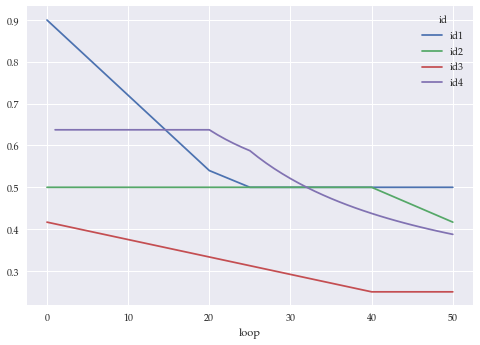

In [22]:
solution['capacityFactor'].unstack('id').plot();

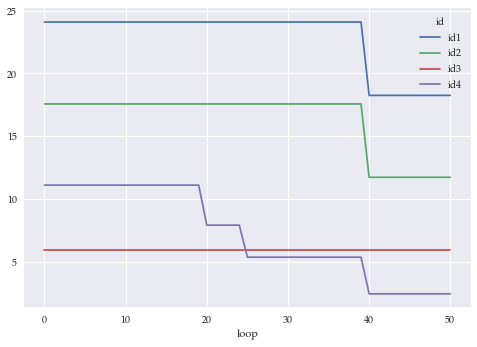

In [23]:
solution['marginalEconomicValue'].unstack('id').plot();

**Slow but clean:**

Let us start by collecting the data in one dataframe with categories. Because the two variables in question are defined over the same index, this is very simple to do:

In [24]:
df = pd.DataFrame({k: solution[k] for k in ('capacityFactor','marginalEconomicValue')})
df

capacityFactor marginalEconomicValue
id  loop                                     
id1 0               0.9             24.092022
    1             0.882             24.092022
    2             0.864             24.092022
    3             0.846             24.092022
    4             0.828             24.092022
...                 ...                   ...
id4 46         0.404891              2.438099
    47         0.400266              2.438099
    48         0.395833              2.438099
    49         0.391582              2.438099
    50           0.3875              2.438099

[204 rows x 2 columns]

Next, we can update the indices to something that is a bit more intuitive. In our model, for instance, the plant ```id```s can be tied to unique 'types' of plants (coal, gas, bio, wind). And, the ```loop``` which is now just integers from 0-50 can be replaced by what we are looping over: The generating capacity of the wind turbine:

In [25]:
idTypes = dict(id1 = 'Coal', id2 = 'Gas', id3 = 'Bio', id4 = 'Wind') # create a map from old-to-new plant id names
loopNames = windGrid.droplevel('id') # create a map from old-to-new loop index names
df.index = df.index.set_levels([df.index.levels[0].map(idTypes),  # update the index using the maps
                                df.index.levels[1].map(loopNames)])
df.index.names = ['Plant type', '$q_W$'] # update the names of the index
df

capacityFactor marginalEconomicValue
Plant type $q_W$                                     
Coal       0.0              0.9             24.092022
           2.0            0.882             24.092022
           4.0            0.864             24.092022
           6.0            0.846             24.092022
           8.0            0.828             24.092022
...                         ...                   ...
Wind       92.0        0.404891              2.438099
           94.0        0.400266              2.438099
           96.0        0.395833              2.438099
           98.0        0.391582              2.438099
           100.0         0.3875              2.438099

[204 rows x 2 columns]

Now, let us plot the two variables in two separate ```subplots```. The following is a somewhat standardized way of creating multiple plots with control over a lot of things. You can try and have a look at the options used here to control axes, limits etc.:

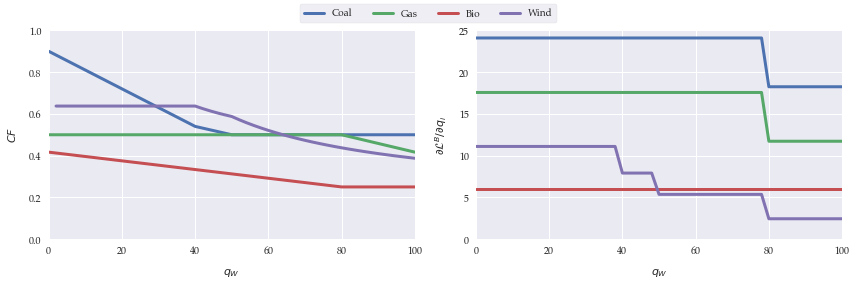

In [26]:
# 1: Control size of the total figure, number of subplots etc.:
nplots = 2
nrows = math.ceil(nplots/2)
fig, axes = plt.subplots(nrows, min(nplots, 2), figsize = (12, (4*nrows)));
plt.subplots_adjust(hspace=0.35) # create a bit of extra space between subplots

# 2: Plot capacityFactor:
ax = plt.subplot(nrows, min(nplots,2), 1) # access subplot 1
df_i = df['capacityFactor'].unstack('Plant type')
df_i.plot(ax=ax, legend=False, linewidth=3); # drop the legend from this specific subplot
ax.set_xlabel('$q_W$', labelpad=10); # set label on the x-axis; labelpad specifies distance from axis to edges of the plot 
ax.set_ylabel("$CF$", labelpad=10); # set label on the y-axis
ax.set_xlim([df_i.index.min(), df_i.index.max()]); # set limits on x-axis
ax.set_ylim([0, 1]); # set limits on the y-axis

# 3: Plot marginalEconomicValue; repeat from subplot 1
ax = plt.subplot(nrows, min(nplots,2), 2) # access subplot 2
df_i = df['marginalEconomicValue'].unstack('Plant type')
df_i.plot(ax=ax, legend=False, linewidth=3);
ax.set_xlabel('$q_W$', labelpad=10);
ax.set_ylabel("$\partial \mathcal{L}^B/\partial q_i$",labelpad=10); 
ax.set_xlim([df_i.index.min(), df_i.index.max()]); # set limits on x-axis
ax.set_ylim([0, math.ceil(df['marginalEconomicValue'].max()/5) * 5]); # set upper limit on the y-axis as the nearest integer larger than max that is divisible by 5 

# 4: Add one legend for the whole figure; this can be nice to use this when subplots share the same legend.
fig.legend(df_i.columns, loc = 9, ncol = 4, frameon=True) # add columns as legends above the plot
fig.tight_layout(); # auxiliary function that often makes the plot look a bit nicer
fig.subplots_adjust(top=0.9); # make room for the legends to be above the plot

#### 4.3. *Explain results:*

It is very useful to have the merit order curves present in order to explain the results here - so, they are printed here again for convenience:

In [27]:
IFrame("Misc/Figs/mBasicInt_MeritOrder.pdf", width=600, height=300)

We could for example comment on:
* **When there is little wind generation**: The marginal supply most often comes from the coal plant, but also sometimes from the biomass plant. If we compare to the merit order curve for the four hours of the model, this makes pretty good sense: 
    * For $h=1,4$ the base load is covered by wind and coal only. Thus, when we introduce wind here, coal is crowded out; this results in a lower capacity factor for the coal-fired plant. 
    * For $h=2$, the peak load is covered by the more expensive biomass powered plant. Thus, when we introduce wind in these hours, the capacity factor drops here. 
    * For $h=4$, all plants work at full capacity; equilibrium is etablished through load shedding. Thus, when we introduce wind here, the capacity factors of the other plants do not change.
* **When wind generation exceeds $40$ and $50$ GJ/h**: Wind starts to cover *more* than the base load in hours $h=1,4$. Thus, the capacity factor of the wind technology drops and with it the marginal economic value of generation capacity. 
* **When wind generation exceeds $80$ GJ/h**: The marginal supply with peak load $h=2$ shifts from the biomass plant to the gas plant. Thus, the marginal system costs decreases. As wind, coal, and gas plants are all active in this hour, this affects the profitability of all these plants: Now they are no longer crowding out the very expensive biomass plant, but instead the less expensive natural gas plant. 